In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# Load a larger dataset (replace with your large dataset path)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
data = pd.read_csv(url, names=columns)

In [55]:
# Preprocess the data
print("Initial data shape:", data.shape)
data.replace("?", np.nan, inplace=True)  # Replace missing values
data.dropna(inplace=True)  # Drop rows with missing values
data = data.astype(float)  # Convert all columns to numeric
print("Data shape after cleaning:", data.shape)

Initial data shape: (303, 14)
Data shape after cleaning: (297, 14)


In [56]:
# Convert target variable to binary (0 for no disease, 1 for heart disease)
data['target'] = (data['target'] > 0).astype(int)

In [57]:
# Exploratory Data Analysis (EDA)
print("\nDataset Information:")
print(data.info())
print("\nTarget Distribution:")
print(data['target'].value_counts())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB
None

Target Distribution:
target
0    160
1    137
Name: count, dtype: int64


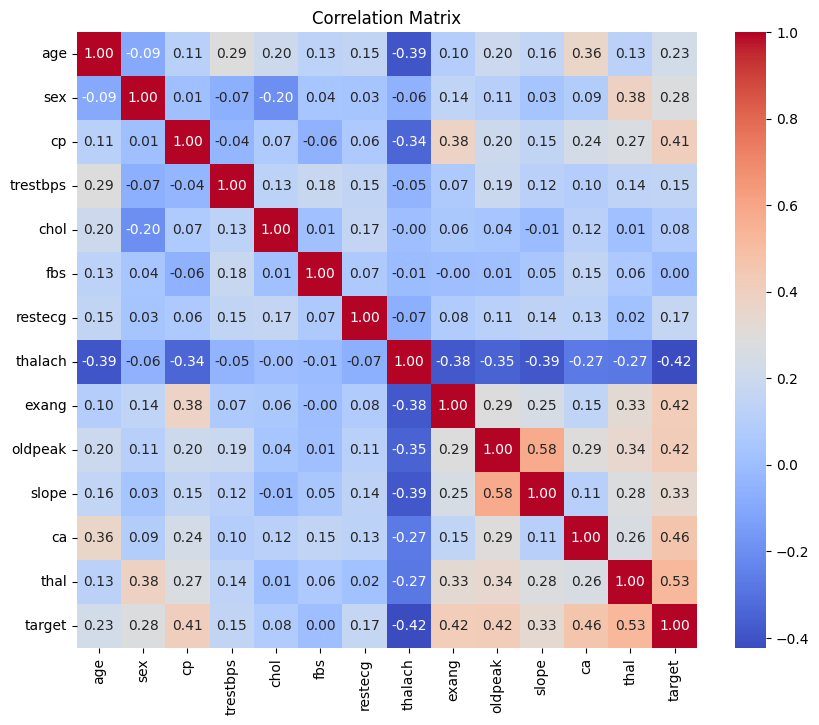

In [58]:
# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [59]:
# Define features and target
X = data.drop('target', axis=1)
y = data['target']

In [60]:
# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [61]:
# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [62]:
#Define the model
model = RandomForestClassifier(random_state=42)

In [63]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

In [64]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'thalach',
                                                                          'oldpeak']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'cp',
                                                                          'fbs',
                                                                          'restecg',
                                                                          'exang',
                                                                          'slope',
                                                                          'ca',
                                                                          'thal'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

In [66]:
# Best parameters and model evaluation
print("\nBest Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_



Best Parameters: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 300}


In [67]:
# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [68]:
# Evaluate the model
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Model Performance:
Accuracy: 0.8833333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

ROC-AUC Score: 0.9629629629629629


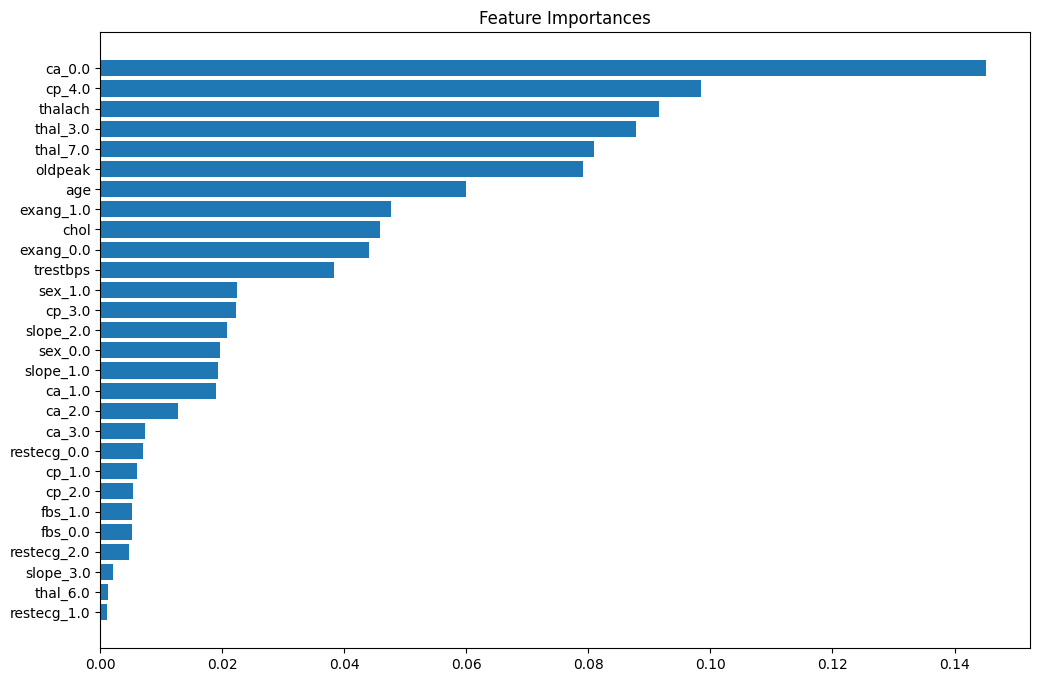

In [69]:
# Feature importance visualization
if hasattr(best_model['model'], 'feature_importances_'):
    feature_names = numerical_features + list(best_model['preprocessor'].transformers_[1][1].get_feature_names_out())
    feature_importances = best_model['model'].feature_importances_
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.title('Feature Importances')
    plt.show()